# Notebook to convert Tensorflow CNN to tflite

In [1]:
!python -m ipykernel install --user --name=model-maker

Installed kernelspec model-maker in C:\Users\allen\AppData\Roaming\jupyter\kernels\model-maker


In [2]:
import os

os.environ["VIRTUAL_ENV"]

'F:\\Home\\AMS\\model-maker'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tflite_model_maker import model_spec, object_detector
from tflite_model_maker.config import ExportFormat, QuantizationConfig

assert tf.__version__.startswith("2")

tf.get_logger().setLevel("ERROR")
from absl import logging

logging.set_verbosity(logging.ERROR)
pd.options.mode.chained_assignment = None

F:\Home\AMS\model-maker\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
F:\Home\AMS\model-maker\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
CSV_DATA_PATH = "dataset_tf_csv"

In [5]:
spec = model_spec.get("efficientdet_lite0")

In [6]:
train_data, validation_data, test_data = object_detector.DataLoader.from_csv(f"{CSV_DATA_PATH}/data.csv")

In [7]:
model = object_detector.create(train_data, model_spec=spec, batch_size=8, epochs=50, train_whole_model=False, validation_data=validation_data)

Epoch 1/50
72/72 [==============================] - 36s 164ms/step - det_loss: 2.4993 - cls_loss: 1.2313 - box_loss: 0.0254 - reg_l2_loss: 0.0046 - loss: 2.5040 - learning_rate: 0.0090 - gradient_norm: 2.8052 - val_det_loss: 1.8951 - val_cls_loss: 1.2215 - val_box_loss: 0.0135 - val_reg_l2_loss: 0.0047 - val_loss: 1.8997
Epoch 2/50
72/72 [==============================] - 10s 135ms/step - det_loss: 1.6368 - cls_loss: 0.9277 - box_loss: 0.0142 - reg_l2_loss: 0.0047 - loss: 1.6415 - learning_rate: 0.0100 - gradient_norm: 2.8870 - val_det_loss: 1.5940 - val_cls_loss: 0.8404 - val_box_loss: 0.0151 - val_reg_l2_loss: 0.0048 - val_loss: 1.5988
Epoch 3/50
72/72 [==============================] - 10s 145ms/step - det_loss: 1.4871 - cls_loss: 0.8241 - box_loss: 0.0133 - reg_l2_loss: 0.0048 - loss: 1.4919 - learning_rate: 0.0099 - gradient_norm: 3.1227 - val_det_loss: 1.2646 - val_cls_loss: 0.8912 - val_box_loss: 0.0075 - val_reg_l2_loss: 0.0049 - val_loss: 1.2695
Epoch 4/50
72/72 [=============

In [8]:
model.evaluate(test_data)

4/4 [==============================] - 13s 2s/step



{'AP': 0.052887607,
 'AP50': 0.09689554,
 'AP75': 0.046515875,
 'APs': 0.0017084224,
 'APm': 0.038456276,
 'APl': 0.47203392,
 'ARmax1': 0.11201474,
 'ARmax10': 0.2007371,
 'ARmax100': 0.22093263,
 'ARs': 0.054551136,
 'ARm': 0.26008442,
 'ARl': 0.73125,
 'AP_/other': 0.07475914,
 'AP_/mandatory': 0.008130757,
 'AP_/prohibitory': 0.0602817,
 'AP_/danger': 0.068378836}

In [7]:
model.export(export_dir='.', saved_model_filename="detector4.tflite")

In [6]:
model = object_detector.EfficientDetLite4Spec()

In [8]:
model.evaluate_tflite('detector4.tflite', test_data, steps=1)

AttributeError: 'DataLoader' object has no attribute 'take'

## Run inference on tflite model

In [25]:
import platform
from typing import List, NamedTuple
import json

import cv2

Interpreter = tf.lite.Interpreter
load_delegate = tf.lite.experimental.load_delegate

# pylint: enable=g-import-not-at-top


class ObjectDetectorOptions(NamedTuple):
  """A config to initialize an object detector."""

  enable_edgetpu: bool = False
  """Enable the model to run on EdgeTPU."""

  label_allow_list: List[str] = None
  """The optional allow list of labels."""

  label_deny_list: List[str] = None
  """The optional deny list of labels."""

  max_results: int = -1
  """The maximum number of top-scored detection results to return."""

  num_threads: int = 1
  """The number of CPU threads to be used."""

  score_threshold: float = 0.0
  """The score threshold of detection results to return."""


class Rect(NamedTuple):
  """A rectangle in 2D space."""
  left: float
  top: float
  right: float
  bottom: float


class Category(NamedTuple):
  """A result of a classification task."""
  label: str
  score: float
  index: int


class Detection(NamedTuple):
  """A detected object as the result of an ObjectDetector."""
  bounding_box: Rect
  categories: List[Category]


def edgetpu_lib_name():
  """Returns the library name of EdgeTPU in the current platform."""
  return {
      'Darwin': 'libedgetpu.1.dylib',
      'Linux': 'libedgetpu.so.1',
      'Windows': 'edgetpu.dll',
  }.get(platform.system(), None)


class ObjectDetector:
  """A wrapper class for a TFLite object detection model."""

  _OUTPUT_LOCATION_NAME = 'location'
  _OUTPUT_CATEGORY_NAME = 'category'
  _OUTPUT_SCORE_NAME = 'score'
  _OUTPUT_NUMBER_NAME = 'number of detections'

  def __init__(
      self,
      model_path: str,
      options: ObjectDetectorOptions = ObjectDetectorOptions()
  ) -> None:
    """Initialize a TFLite object detection model.
    Args:
        model_path: Path to the TFLite model.
        options: The config to initialize an object detector. (Optional)
    Raises:
        ValueError: If the TFLite model is invalid.
        OSError: If the current OS isn't supported by EdgeTPU.
    """

    # Load metadata from model.
    displayer = metadata.MetadataDisplayer.with_model_file(model_path)

    # Save model metadata for preprocessing later.
    model_metadata = json.loads(displayer.get_metadata_json())
    process_units = model_metadata['subgraph_metadata'][0]['input_tensor_metadata'][0]['process_units']
    mean = 0.0
    std = 1.0
    for option in process_units:
      if option['options_type'] == 'NormalizationOptions':
        mean = option['options']['mean'][0]
        std = option['options']['std'][0]
    self._mean = mean
    self._std = std

    # Load label list from metadata.
    file_name = displayer.get_packed_associated_file_list()[0]
    label_map_file = displayer.get_associated_file_buffer(file_name).decode()
    label_list = list(filter(lambda x: len(x) > 0, label_map_file.splitlines()))
    self._label_list = label_list

    # Initialize TFLite model.
    if options.enable_edgetpu:
      if edgetpu_lib_name() is None:
        raise OSError("The current OS isn't supported by Coral EdgeTPU.")
      interpreter = Interpreter(
          model_path=model_path,
          experimental_delegates=[load_delegate(edgetpu_lib_name())],
          num_threads=options.num_threads)
    else:
      interpreter = Interpreter(
          model_path=model_path, num_threads=options.num_threads)

    interpreter.allocate_tensors()
    input_detail = interpreter.get_input_details()[0]

    # From TensorFlow 2.6, the order of the outputs become undefined.
    # Therefore we need to sort the tensor indices of TFLite outputs and to know
    # exactly the meaning of each output tensor. For example, if
    # output indices are [601, 599, 598, 600], tensor names and indices aligned
    # are:
    #   - location: 598
    #   - category: 599
    #   - score: 600
    #   - detection_count: 601
    # because of the op's ports of TFLITE_DETECTION_POST_PROCESS
    # (https://github.com/tensorflow/tensorflow/blob/a4fe268ea084e7d323133ed7b986e0ae259a2bc7/tensorflow/lite/kernels/detection_postprocess.cc#L47-L50).
    sorted_output_indices = sorted(
        [output['index'] for output in interpreter.get_output_details()])
    self._output_indices = {
        self._OUTPUT_LOCATION_NAME: sorted_output_indices[0],
        self._OUTPUT_CATEGORY_NAME: sorted_output_indices[1],
        self._OUTPUT_SCORE_NAME: sorted_output_indices[2],
        self._OUTPUT_NUMBER_NAME: sorted_output_indices[3],
    }

    self._input_size = input_detail['shape'][2], input_detail['shape'][1]
    self._is_quantized_input = input_detail['dtype'] == np.uint8
    self._interpreter = interpreter
    self._options = options

  def detect(self, input_image: np.ndarray) -> List[Detection]:
    """Run detection on an input image.
    Args:
        input_image: A [height, width, 3] RGB image. Note that height and width
          can be anything since the image will be immediately resized according
          to the needs of the model within this function.
    Returns:
        A Person instance.
    """
    image_height, image_width, _ = input_image.shape

    input_tensor = self._preprocess(input_image)

    self._set_input_tensor(input_tensor)
    self._interpreter.invoke()

    # Get all output details
    boxes = self._get_output_tensor(self._OUTPUT_LOCATION_NAME)
    classes = self._get_output_tensor(self._OUTPUT_CATEGORY_NAME)
    scores = self._get_output_tensor(self._OUTPUT_SCORE_NAME)
    count = int(self._get_output_tensor(self._OUTPUT_NUMBER_NAME))

    return self._postprocess(boxes, classes, scores, count, image_width,
                             image_height)

  def _preprocess(self, input_image: np.ndarray) -> np.ndarray:
    """Preprocess the input image as required by the TFLite model."""

    # Resize the input
    input_tensor = cv2.resize(input_image, self._input_size)

    # Normalize the input if it's a float model (aka. not quantized)
    if not self._is_quantized_input:
      input_tensor = (np.float32(input_tensor) - self._mean) / self._std

    # Add batch dimension
    input_tensor = np.expand_dims(input_tensor, axis=0)

    return input_tensor

  def _set_input_tensor(self, image):
    """Sets the input tensor."""
    tensor_index = self._interpreter.get_input_details()[0]['index']
    input_tensor = self._interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image

  def _get_output_tensor(self, name):
    """Returns the output tensor at the given index."""
    output_index = self._output_indices[name]
    tensor = np.squeeze(self._interpreter.get_tensor(output_index))
    return tensor

  def _postprocess(self, boxes: np.ndarray, classes: np.ndarray,
                   scores: np.ndarray, count: int, image_width: int,
                   image_height: int) -> List[Detection]:
    """Post-process the output of TFLite model into a list of Detection objects.
    Args:
        boxes: Bounding boxes of detected objects from the TFLite model.
        classes: Class index of the detected objects from the TFLite model.
        scores: Confidence scores of the detected objects from the TFLite model.
        count: Number of detected objects from the TFLite model.
        image_width: Width of the input image.
        image_height: Height of the input image.
    Returns:
        A list of Detection objects detected by the TFLite model.
    """
    results = []

    # Parse the model output into a list of Detection entities.
    for i in range(count):
      if scores[i] >= self._options.score_threshold:
        y_min, x_min, y_max, x_max = boxes[i]
        bounding_box = Rect(
            top=int(y_min * image_height),
            left=int(x_min * image_width),
            bottom=int(y_max * image_height),
            right=int(x_max * image_width))
        class_id = int(classes[i])
        category = Category(
            score=scores[i],
            label=self._label_list[class_id],  # 0 is reserved for background
            index=class_id)
        result = Detection(bounding_box=bounding_box, categories=[category])
        results.append(result)

    # Sort detection results by score ascending
    sorted_results = sorted(
        results,
        key=lambda detection: detection.categories[0].score,
        reverse=True)

    # Filter out detections in deny list
    filtered_results = sorted_results
    if self._options.label_deny_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label not in self.
              _options.label_deny_list, filtered_results))

    # Keep only detections in allow list
    if self._options.label_allow_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label in self._options.
              label_allow_list, filtered_results))

    # Only return maximum of max_results detection.
    if self._options.max_results > 0:
      result_count = min(len(filtered_results), self._options.max_results)
      filtered_results = filtered_results[:result_count]

    return filtered_results


_MARGIN = 10  # pixels
_ROW_SIZE = 10  # pixels
_FONT_SIZE = 1
_FONT_THICKNESS = 1
_TEXT_COLOR = (0, 0, 255)  # red


def visualize(
    image: np.ndarray,
    detections: List[Detection],
) -> np.ndarray:
    
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detections: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  idx = 0
  for detection in detections:
    # Draw bounding_box
    start_point = detection.bounding_box.left, detection.bounding_box.top
    end_point = detection.bounding_box.right, detection.bounding_box.bottom
    rect = image[detection.bounding_box.top:detection.bounding_box.bottom, detection.bounding_box.left:detection.bounding_box.right]
    # rect = cv2.rectangle(image, start_point, end_point, _TEXT_COLOR, 1)
    img = Image.fromarray(rect)
    img.save(f"det_{idx}.png")
    idx += 1 
    # Draw label and score
    # category = detection.categories[0]
    # class_name = category.label
    # probability = round(category.score, 2)
    # result_text = class_name + ' (' + str(probability) + ')'
    # text_location = (_MARGIN + detection.bounding_box.left,
    #                  _MARGIN + _ROW_SIZE + detection.bounding_box.top)
    # cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
    #             _FONT_SIZE, _TEXT_COLOR, _FONT_THICKNESS)

  return image

C:\Users\allen\AppData\Local\Temp\ipykernel_22436\3915475550.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image.thumbnail((512, 512), Image.ANTIALIAS)


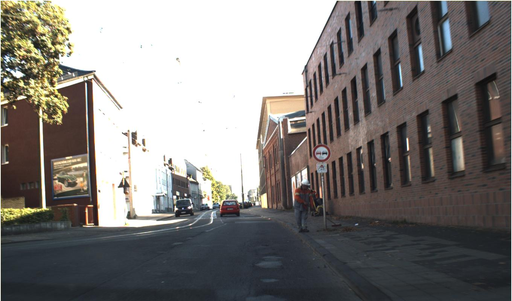

In [32]:
from PIL import Image
from tflite_support import metadata

DETECTION_THRESHOLD = 0.35
TFLITE_MODEL_PATH = "detector.tflite" 

TEMP_FILE = 'FullIJCNN2013/00080.jpg'

image = Image.open(TEMP_FILE).convert('RGB')
image.thumbnail((512, 512), Image.ANTIALIAS)
image_np = np.asarray(image)

# Load the TFLite model
options = ObjectDetectorOptions(
      num_threads=4,
      score_threshold=DETECTION_THRESHOLD,
)
detector = ObjectDetector(model_path=TFLITE_MODEL_PATH, options=options)

# Run object detection estimation using the model.
detections = detector.detect(image_np)

# Draw keypoints and edges on input image
image_np = visualize(image_np, detections)

# Show the detection result
Image.fromarray(image_np)

## Convert to tf object detection format

In [10]:
DATA_PATH = "FullIJCNN2013"
ppm_bb_params = ["xmin", "ymin", "xmax", "ymax"]
column_names = ["filename"] + ppm_bb_params + ["class"]

In [11]:
data = pd.read_csv(
    f"{DATA_PATH}/gt.txt",
    sep=";",
    names=column_names,
)
data["width"] = np.zeros(len(data))
data["height"] = np.zeros(len(data))
data["Class_name"] = np.zeros(len(data))
data

,filename,xmin,ymin,xmax,ymax,class,width,height,Class_name
0,00000.ppm,774,411,815,446,11,0.0,0.0,0.0
1,00001.ppm,983,388,1024,432,40,0.0,0.0,0.0
2,00001.ppm,386,494,442,552,38,0.0,0.0,0.0
3,00001.ppm,973,335,1031,390,13,0.0,0.0,0.0
4,00002.ppm,892,476,1006,592,39,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1208,00896.ppm,808,412,846,450,15,0.0,0.0,0.0
1209,00897.ppm,804,526,828,550,42,0.0,0.0,0.0
1210,00898.ppm,323,504,355,536,4,0.0,0.0,0.0
1211,00898.ppm,817,510,849,542,4,0.0,0.0,0.0


In [12]:
prohibitory = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 16]
danger = [11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
mandatory = [33, 34, 35, 36, 37, 38, 39, 40]
other = [6, 12, 13, 14, 17, 32, 41, 42]

for i, item in data.iterrows():
    img = Image.open(f"{DATA_PATH}/" + data["filename"][0])
    img = np.array(img)
    height, width, _ = img.shape
    data["width"][i] = width
    data["height"][i] = height
    data["filename"][i] = data["filename"][i][:-4] + ".jpg"
    if data["class"][i] in prohibitory:
        data["class"][i] = 0
        data["Class_name"][i] = "prohibitory"
    elif data["class"][i] in danger:
        data["class"][i] = 1
        data["Class_name"][i] = "danger"
    elif data["class"][i] in mandatory:
        data["class"][i] = 2
        data["Class_name"][i] = "mandatory"
    elif data["class"][i] in other:
        data["class"][i] = 3
        data["Class_name"][i] = "other"

In [13]:
data

,filename,xmin,ymin,xmax,ymax,class,width,height,Class_name
0,00000.jpg,774,411,815,446,1,1360.0,800.0,danger
1,00001.jpg,983,388,1024,432,2,1360.0,800.0,mandatory
2,00001.jpg,386,494,442,552,2,1360.0,800.0,mandatory
3,00001.jpg,973,335,1031,390,3,1360.0,800.0,other
4,00002.jpg,892,476,1006,592,2,1360.0,800.0,mandatory
...,...,...,...,...,...,...,...,...,...
1208,00896.jpg,808,412,846,450,0,1360.0,800.0,prohibitory
1209,00897.jpg,804,526,828,550,3,1360.0,800.0,other
1210,00898.jpg,323,504,355,536,0,1360.0,800.0,prohibitory
1211,00898.jpg,817,510,849,542,0,1360.0,800.0,prohibitory


In [14]:
df = pd.DataFrame(columns=["set", "file", "label", "v1x", "v1y", "v2x", "v2y","v3x", "v3y","v4x", "v4y"])
df["set"] = np.zeros(len(data))
df

,set,file,label,v1x,v1y,v2x,v2y,v3x,v3y,v4x,v4y
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1208,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1209,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1210,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1211,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
for idx, item in data.iterrows():
    df["file"][idx] = f"{DATA_PATH}/{item['filename']}"
    
    df["label"][idx] = item["Class_name"]
    x_rel_min = item["xmin"] / item["width"]
    x_rel_max = item["xmax"] / item["width"]
    y_rel_min = item["ymin"] / item["height"]
    y_rel_max = item["ymax"] / item["height"]
    
    # vertex 1
    df["v1x"][idx] = x_rel_min
    df["v1y"][idx] = y_rel_min
    
    # vertex 2
    df["v2x"][idx] = x_rel_max
    df["v2y"][idx] = y_rel_min
    
    # vertex 3
    df["v3x"][idx] = x_rel_max
    df["v3y"][idx] = y_rel_max
    
    # vertex 4
    df["v4x"][idx] = x_rel_min
    df["v4y"][idx] = y_rel_max

In [16]:
df

,set,file,label,v1x,v1y,v2x,v2y,v3x,v3y,v4x,v4y
0,0.0,FullIJCNN2013/00000.jpg,danger,0.569118,0.51375,0.599265,0.51375,0.599265,0.5575,0.569118,0.5575
1,0.0,FullIJCNN2013/00001.jpg,mandatory,0.722794,0.485,0.752941,0.485,0.752941,0.54,0.722794,0.54
2,0.0,FullIJCNN2013/00001.jpg,mandatory,0.283824,0.6175,0.325,0.6175,0.325,0.69,0.283824,0.69
3,0.0,FullIJCNN2013/00001.jpg,other,0.715441,0.41875,0.758088,0.41875,0.758088,0.4875,0.715441,0.4875
4,0.0,FullIJCNN2013/00002.jpg,mandatory,0.655882,0.595,0.739706,0.595,0.739706,0.74,0.655882,0.74
...,...,...,...,...,...,...,...,...,...,...,...
1208,0.0,FullIJCNN2013/00896.jpg,prohibitory,0.594118,0.515,0.622059,0.515,0.622059,0.5625,0.594118,0.5625
1209,0.0,FullIJCNN2013/00897.jpg,other,0.591176,0.6575,0.608824,0.6575,0.608824,0.6875,0.591176,0.6875
1210,0.0,FullIJCNN2013/00898.jpg,prohibitory,0.2375,0.63,0.261029,0.63,0.261029,0.67,0.2375,0.67
1211,0.0,FullIJCNN2013/00898.jpg,prohibitory,0.600735,0.6375,0.624265,0.6375,0.624265,0.6775,0.600735,0.6775


In [17]:
from sklearn.model_selection import train_test_split

df_train, df_test, _, _ = train_test_split(
    df, df, test_size=0.2, random_state=42, stratify=df["label"]
)
df_train, df_val, _, _ = train_test_split(
    df_train, df_train, test_size=0.15, random_state=42, stratify=df_train["label"]
)

In [18]:
# Rename "set" to corresponding set after splitting
df_train["set"] = "TRAIN"
df_val["set"] = "VALIDATION"
df_test["set"] = "TEST"

In [19]:
result_df = pd.concat([df_train, df_val, df_test])
result_df

,set,file,label,v1x,v1y,v2x,v2y,v3x,v3y,v4x,v4y
1104,TRAIN,FullIJCNN2013/00809.jpg,other,0.506618,0.44875,0.529412,0.44875,0.529412,0.49,0.506618,0.49
987,TRAIN,FullIJCNN2013/00715.jpg,mandatory,0.209559,0.4325,0.258088,0.4325,0.258088,0.515,0.209559,0.515
349,TRAIN,FullIJCNN2013/00220.jpg,prohibitory,0.828676,0.35625,0.858824,0.35625,0.858824,0.4075,0.828676,0.4075
1091,TRAIN,FullIJCNN2013/00797.jpg,other,0.604412,0.52125,0.638235,0.52125,0.638235,0.57125,0.604412,0.57125
424,TRAIN,FullIJCNN2013/00268.jpg,prohibitory,0.655147,0.495,0.674265,0.495,0.674265,0.5275,0.655147,0.5275
...,...,...,...,...,...,...,...,...,...,...,...
601,TEST,FullIJCNN2013/00379.jpg,prohibitory,0.780882,0.5525,0.815441,0.5525,0.815441,0.61125,0.780882,0.61125
236,TEST,FullIJCNN2013/00149.jpg,other,0.816176,0.1975,0.905147,0.1975,0.905147,0.34125,0.816176,0.34125
289,TEST,FullIJCNN2013/00184.jpg,prohibitory,0.580882,0.34125,0.625,0.34125,0.625,0.4175,0.580882,0.4175
757,TEST,FullIJCNN2013/00482.jpg,other,0.191176,0.66,0.217647,0.66,0.217647,0.7125,0.191176,0.7125


In [21]:
result_df.to_csv(f"{CSV_DATA_PATH}/data.csv", index=False)

In [1]:
df_train.to_csv(f"{CSV_DATA_PATH}/train.csv", index=False)
df_val.to_csv(f"{CSV_DATA_PATH}/val.csv", index=False)
df_test.to_csv(f"{CSV_DATA_PATH}/test.csv", index=False)

NameError: name 'df_train' is not defined